# Import Libraries




In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
# mpl.rcParams["text.usetex"] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 16

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

# Load and Prepare Dataset


In [8]:
# Loading the data
train_df = pd.read_csv('data/medical_tc_train.csv')
test_df = pd.read_csv('data/medical_tc_test.csv')
train_df.columns = ["label", "text"]
test_df.columns = ["label", "text"]

# Combine the data
df = pd.concat([train_df, test_df], ignore_index=True)
print(f"Total samples: {len(df)}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=0
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Total samples: 14438
Train: 11550, Test: 2888


# Text Preprocessing and Cleaning


In [9]:
# Download NLTK
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt_tab', quiet=True) # Added missing download

# Preprocessing tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Tokenize
token_X_train = [word_tokenize(text) for text in X_train]
token_X_test = [word_tokenize(text) for text in X_test]

# Lemmatize
lemma_X_train = [[lemmatizer.lemmatize(word) for word in tokens] for tokens in token_X_train]
lemma_X_test = [[lemmatizer.lemmatize(word) for word in tokens] for tokens in token_X_test]

# Remove stopwords
clear_X_train = [[word for word in tokens if word.lower() not in stop_words] for tokens in lemma_X_train]
clear_X_test = [[word for word in tokens if word.lower() not in stop_words] for tokens in lemma_X_test]

# Join back
X_train_processed = [' '.join(tokens) for tokens in clear_X_train]
X_test_processed = [' '.join(tokens) for tokens in clear_X_test]

# Prepare Data for RNN Model


In [11]:
# Settings
MAX_WORDS = 5000
MAX_LEN = 200

# Tokenize
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_processed)
X_train_seq = tokenizer.texts_to_sequences(X_train_processed)
X_test_seq = tokenizer.texts_to_sequences(X_test_processed)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

# Adjust labels (1-5 to 0-4)
# y_train_adj = y_train.values - 1
# y_test_adj = y_test.values - 1
y_train_adj = np.where(y_train > 4, 0, y_train)
y_test_adj = np.where(y_test > 4, 0, y_test)

# Class weights
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train_adj), y=y_train_adj)
class_weights = {i: class_weights_array[i] for i in range(5)}
print(f"Vocab: {MAX_WORDS}, Max Length: {MAX_LEN}")
print(f"Train shape: {X_train_pad.shape}")

Vocab: 5000, Max Length: 200
Train shape: (11550, 200)


# Build, Train, and Evaluate LSTM Model


In [14]:
# Build LSTM
model_lstm = Sequential([
    Embedding(MAX_WORDS, 64, input_length=MAX_LEN),
    LSTM(32, return_sequences=True, dropout=0.2),
    GlobalMaxPooling1D(),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model_lstm.compile(
    optimizer=keras.optimizers.Adam(0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_lstm = model_lstm.fit(
    X_train_pad, y_train_adj,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    class_weight=class_weights,
    verbose=1
)

# Evaluate
y_pred_lstm = np.argmax(model_lstm.predict(X_test_pad, verbose=0), axis=1)
acc_lstm = accuracy_score(y_test_adj, y_pred_lstm)
print(f"\nLSTM Accuracy: {acc_lstm:.4f} ({acc_lstm*100:.2f}%)")


2025-11-11 19:07:03.323281: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 26s 159ms/step - accuracy: 0.2718 - loss: 1.7451 - val_accuracy: 0.3247 - val_loss: 1.5855
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 22s 155ms/step - accuracy: 0.3306 - loss: 1.5485 - val_accuracy: 0.4662 - val_loss: 1.4760
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 23s 159ms/step - accuracy: 0.3610 - loss: 1.4592 - val_accuracy: 0.4481 - val_loss: 1.4008
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - accuracy: 0.4128 - loss: 1.3688 - val_accuracy: 0.4684 - val_loss: 1.3032
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step - accuracy: 0.4751 - loss: 1.2795 - val_accuracy: 0.5182 - val_loss: 1.2457
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 22s 154ms/step - accuracy: 0.5076 - loss: 1.1964 - val_accuracy: 0.5290 - val_loss: 1.1894
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.5269 - loss: 1.1293 - val_accuracy: 0.5203 - val_loss: 1.1724
Epoch 8/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.5464 - loss: 1

# Build, Train, and Evaluate GRU Model


In [ ]:
# Build GRU
model_gru = Sequential([
    Embedding(MAX_WORDS, 64, input_length=MAX_LEN),
    GRU(32, return_sequences=True, dropout=0.2),
    GlobalMaxPooling1D(),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model_gru.compile(
    optimizer=keras.optimizers.Adam(0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_gru = model_gru.fit(
    X_train_pad, y_train_adj,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    class_weight=class_weights,
    verbose=1
)

# Evaluate
y_pred_gru = np.argmax(model_gru.predict(X_test_pad, verbose=0), axis=1)
acc_gru = accuracy_score(y_test_adj, y_pred_gru)
print(f"\nGRU Accuracy: {acc_gru:.4f} ({acc_gru*100:.2f}%)")


Epoch 1/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2382 - loss: 1.8016 - val_accuracy: 0.4905 - val_loss: 1.6909
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3796 - loss: 1.6551 - val_accuracy: 0.5433 - val_loss: 1.4100
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4359 - loss: 1.4189 - val_accuracy: 0.5442 - val_loss: 1.2706
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4783 - loss: 1.2987 - val_accuracy: 0.5775 - val_loss: 1.1897
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5165 - loss: 1.1859 - val_accuracy: 0.5939 - val_loss: 1.1292
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5352 - loss: 1.1133 - val_accuracy: 0.5987 - val_loss: 1.0962
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5549 - loss: 1.0738 - val_accuracy: 0.5957 - val_loss: 1.0807
Epoch 8/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5695 - loss: 1.0310 - val_accu

# Build, Train, and Evaluate Bi-LSTM Model


In [ ]:
# Build Bi-LSTM
model_bilstm = Sequential([
    Embedding(MAX_WORDS, 64, input_length=MAX_LEN),
    Bidirectional(LSTM(24, return_sequences=True, dropout=0.2)),
    GlobalMaxPooling1D(),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model_bilstm.compile(
    optimizer=keras.optimizers.Adam(0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_bilstm = model_bilstm.fit(
    X_train_pad, y_train_adj,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    class_weight=class_weights,
    verbose=1
)

# Evaluate
y_pred_bilstm = np.argmax(model_bilstm.predict(X_test_pad, verbose=0), axis=1)
acc_bilstm = accuracy_score(y_test_adj, y_pred_bilstm)
print(f"\nBi-LSTM Accuracy: {acc_bilstm:.4f} ({acc_bilstm*100:.2f}%)")


Epoch 1/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.2121 - loss: 1.7969 - val_accuracy: 0.4333 - val_loss: 1.5958
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.3867 - loss: 1.5413 - val_accuracy: 0.4528 - val_loss: 1.3599
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4190 - loss: 1.4029 - val_accuracy: 0.4541 - val_loss: 1.3041
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4515 - loss: 1.2816 - val_accuracy: 0.4775 - val_loss: 1.2728
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4756 - loss: 1.2007 - val_accuracy: 0.5100 - val_loss: 1.2401
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5004 - loss: 1.1453 - val_accuracy: 0.4987 - val_loss: 1.2849
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5144 - loss: 1.1176 - val_accuracy: 0.5078 - val_loss: 1.2405
Epoch 8/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5275 - loss: 1.0677 - val_accu

# Classification Reports of the RNN Models

In [15]:
# Classification report for LSTM
print("\n LSTM Classification Report ")
print(classification_report(y_test_adj, y_pred_lstm, target_names=[f'class_{i}' for i in range(5)]))

# Classification report for GRU
# print("\n GRU Classification Report ")
# print(classification_report(y_test_adj, y_pred_gru, target_names=[f'class_{i}' for i in range(5)]))

# # Classification report for Bi-LSTM
# print("\n Bi-LSTM Classification Report ")
# print(classification_report(y_test_adj, y_pred_bilstm, target_names=[f'class_{i}' for i in range(5)]))


 LSTM Classification Report 
              precision    recall  f1-score   support

     class_0       0.49      0.16      0.24       935
     class_1       0.69      0.76      0.72       663
     class_2       0.45      0.57      0.50       297
     class_3       0.46      0.56      0.51       386
     class_4       0.51      0.84      0.63       607

    accuracy                           0.54      2888
   macro avg       0.52      0.58      0.52      2888
weighted avg       0.53      0.54      0.49      2888



# Visualize Model Performance and Training Results


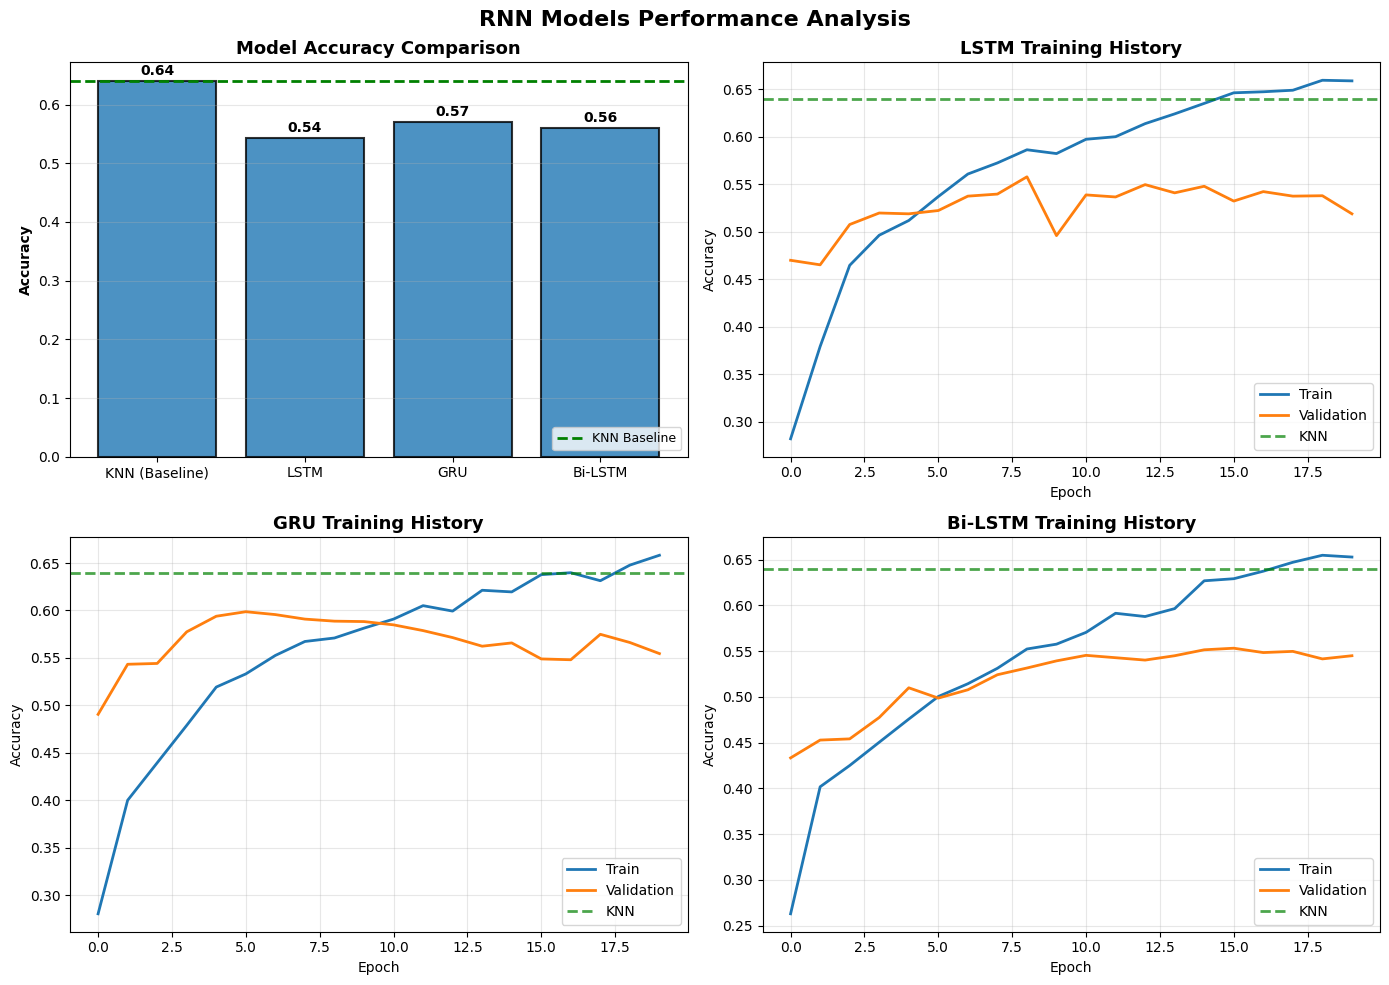

In [ ]:
KNN_BASELINE = 0.64

results = {
    'KNN (Baseline)': KNN_BASELINE,
    'LSTM': acc_lstm,
    'GRU': acc_gru,
    'Bi-LSTM': acc_bilstm,
}


# Graph 1: Model Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Bar chart comparison
ax1 = axes[0, 0]
models = list(results.keys())
accs = list(results.values())

# Create plain bar plot
bars = ax1.bar(models, accs, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.axhline(KNN_BASELINE, color='green', linestyle='--', linewidth=2, label='KNN Baseline')
for bar, acc in zip(bars, accs):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{acc:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Labels and title
ax1.set_ylabel('Accuracy', fontweight='bold')
ax1.set_title('Model Accuracy Comparison', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.legend(loc='lower right', fontsize=9)
plt.tight_layout()


# Plot 2: LSTM Training
ax2 = axes[0, 1]
ax2.plot(history_lstm.history['accuracy'], label='Train', linewidth=2)
ax2.plot(history_lstm.history['val_accuracy'], label='Validation', linewidth=2)
ax2.axhline(KNN_BASELINE, color='green', linestyle='--', linewidth=2, label='KNN', alpha=0.7)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('LSTM Training History', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: GRU Training
ax3 = axes[1, 0]
ax3.plot(history_gru.history['accuracy'], label='Train', linewidth=2)
ax3.plot(history_gru.history['val_accuracy'], label='Validation', linewidth=2)
ax3.axhline(KNN_BASELINE, color='green', linestyle='--', linewidth=2, label='KNN', alpha=0.7)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.set_title('GRU Training History', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Bi-LSTM Training
ax4 = axes[1, 1]
ax4.plot(history_bilstm.history['accuracy'], label='Train', linewidth=2)
ax4.plot(history_bilstm.history['val_accuracy'], label='Validation', linewidth=2)
ax4.axhline(KNN_BASELINE, color='green', linestyle='--', linewidth=2, label='KNN', alpha=0.7)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy')
ax4.set_title('Bi-LSTM Training History', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('RNN Models Performance Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [21]:
df_labels = pd.read_csv("data/medical_tc_labels.csv")
df_labels.loc[df_labels['condition_label'] == 5, 'condition_label'] = 0
df_labels['name'] = df_labels['condition_name'].str.split(n=1, expand=True)[0]
df_labels = df_labels.sort_values(by='condition_label')
df_labels

,condition_label,condition_name,name
4,0,general pathological conditions,general
0,1,neoplasms,neoplasms
1,2,digestive system diseases,digestive
2,3,nervous system diseases,nervous
3,4,cardiovascular diseases,cardiovascular


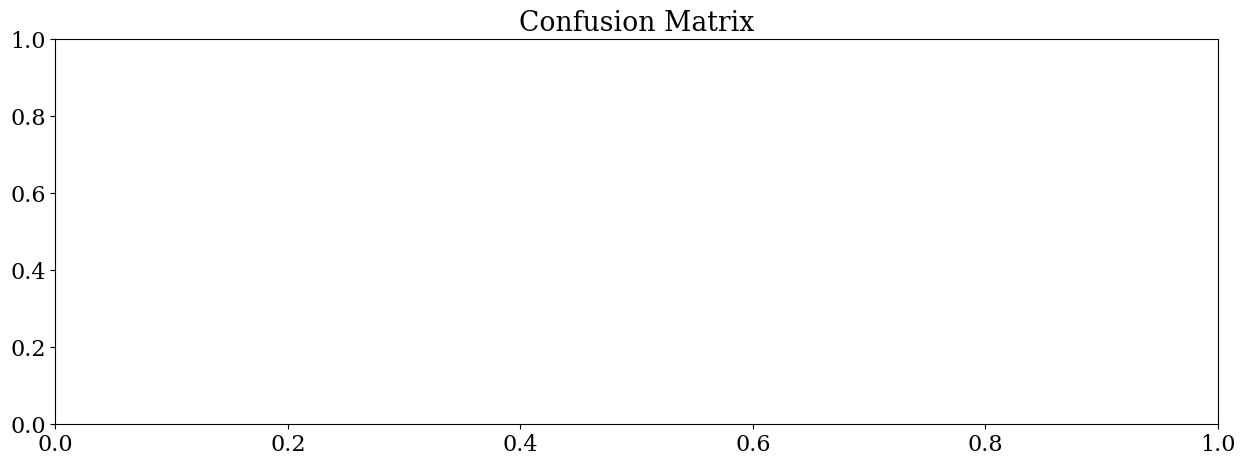

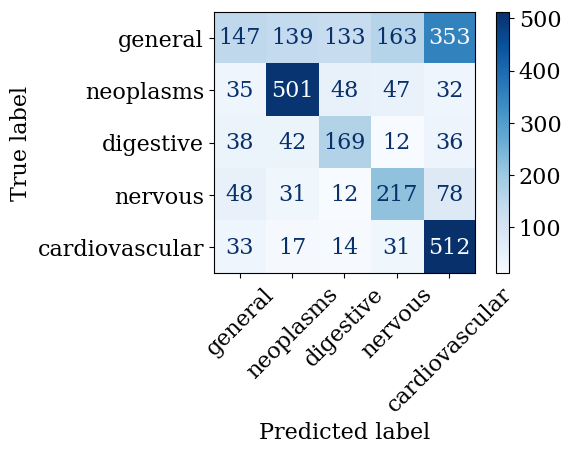

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay
models_data = [
    {'name': 'LSTM', 'y_pred': y_pred_lstm},
    # {'name': 'GRU', 'y_pred': y_pred_gru},
    # {'name': 'Bi-LSTM', 'y_pred': y_pred_bilstm}
]

plt.figure(figsize=(15, 5))
for i, model_data in enumerate(models_data):
    model_name = model_data['name']
    y_pred = model_data['y_pred']

    # Confusion matrix
    cm = confusion_matrix(y_test_adj, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df_labels['name'].values)
    plt.title("Confusion Matrix")
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.savefig("Confusion_RNN.pdf", bbox_inches='tight')

plt.tight_layout()
plt.show()